In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [10]:
##save the raw data as .csv file
input_file = "./taxonomic_data.csv"

data = """species,phylum,count
SpeciesA,Firmicutes,120
SpeciesB,Firmicutes,80
SpeciesC,Bacteroidetes,200
SpeciesD,Bacteroidetes,50
SpeciesE,Proteobacteria,300
SpeciesF,Actinobacteria,150
SpeciesG,Actinobacteria,100
SpeciesH,Firmicutes,70
SpeciesI,Proteobacteria,90
SpeciesJ,Bacteroidetes,60"""

#in the current directory
with open(input_file, "w") as f:
    f.write(data)

#Print confirmation message
print(f"Raw data saved in working folder to '{input_file}'")

Raw data saved in working folder to './taxonomic_data.csv'


In [3]:
##Read the csv flle and show the top 5 rows
df = pd.read_csv(input_file)
print(df.head(10))  #Show the first 5 rows of the df


    species          phylum  count
0  SpeciesA      Firmicutes    120
1  SpeciesB      Firmicutes     80
2  SpeciesC   Bacteroidetes    200
3  SpeciesD   Bacteroidetes     50
4  SpeciesE  Proteobacteria    300
5  SpeciesF  Actinobacteria    150
6  SpeciesG  Actinobacteria    100
7  SpeciesH      Firmicutes     70
8  SpeciesI  Proteobacteria     90
9  SpeciesJ   Bacteroidetes     60


In [4]:
##Set up missing value options
missing_value_handling = {
    "drop_rows_threshold": 0.05,  #Remove rows if missing values are less than 5% of the dataset
    "drop_columns_threshold": 0.4,  #Remove columns if more than 40% of values are missing
    "imputation": {
        "zero_imputation": False,  #Replace missing counts with 0 if applicable
        "mean_imputation": False,  #Use mean for numerical data
        "median_imputation": True,  #Use median for numerical data if data is skewed
        "mode_imputation": True,  #Use mode for categorical data
        "forward_fill": False,  #Forward fill for sequential missing data
        "backward_fill": False  #Backward fill for sequential missing data
    }
}


##Function to handle missing values based on the configuration
def handle_missing_values(df):
    #Drop rows if missing values are a small percentage of the dataset
    row_threshold = int(len(df) * missing_value_handling["drop_rows_threshold"])
    df.dropna(thresh=df.shape[1] - row_threshold, inplace=True)
    
    #Drop columns if too many values are missing
    col_threshold = int(df.shape[0] * missing_value_handling["drop_columns_threshold"])
    df.dropna(axis=1, thresh=col_threshold, inplace=True)
    
    #Impute missing counts with zero if specified
    if missing_value_handling["imputation"]["zero_imputation"]:
        df["count"].fillna(0, inplace=True)
    
    return df

#The list above is not exhuastive, but are very basic procedures for a low dim file.
##There are of course different ways to sort of missing values depending on the complexity. 

#Apply the missing value handling function and display the top 5 rows
df = handle_missing_values(df)
print(df.head())  #Show the first 5 rows after repairing any missing values

    species          phylum  count
0  SpeciesA      Firmicutes    120
1  SpeciesB      Firmicutes     80
2  SpeciesC   Bacteroidetes    200
3  SpeciesD   Bacteroidetes     50
4  SpeciesE  Proteobacteria    300


In [16]:
##Calculate and save summary statistics for each phylum
def calculate_statistics(df, output_file="phylum_summary_statistics.csv"):
    #Group by phylum and calculate multiple summary statistics
    summary = df.groupby("phylum")["count"].agg(
        total_count="sum",
        average_count="mean",
        std_dev="std",
        min_count="min",
        max_count="max"
    ).reset_index()
    
    #Round all values to 2 decimal places
    summary = summary.round(2)
    
    #Save the summary statistics to a csv
    summary.to_csv(output_file, index=False)
    print(f"Summary statistics saved to {output_file}")
    
    #Print the summary df
    print(summary)
    
    return summary

#Example usage
summary_df = calculate_statistics(df)

Summary statistics saved to phylum_summary_statistics.csv
           phylum  total_count  average_count  std_dev  min_count  max_count
0  Actinobacteria          250         125.00    35.36        100        150
1   Bacteroidetes          310         103.33    83.86         50        200
2      Firmicutes          270          90.00    26.46         70        120
3  Proteobacteria          390         195.00   148.49         90        300


In [6]:
#Calculate the average species count and standard deviation for each phylum
averages_df = df.groupby("phylum")["count"].agg(["mean", "std"]).reset_index()
averages_df.rename(columns={"mean": "average_count", "std": "std_dev"}, inplace=True)

#Round all values to 2 decimal places
averages_df = averages_df.round(2)

#Display the averages_df df
print(averages_df)

           phylum  average_count  std_dev
0  Actinobacteria         125.00    35.36
1   Bacteroidetes         103.33    83.86
2      Firmicutes          90.00    26.46
3  Proteobacteria         195.00   148.49


Plot saved to ./total_species_count_stacked.jpeg


<Figure size 600x600 with 0 Axes>

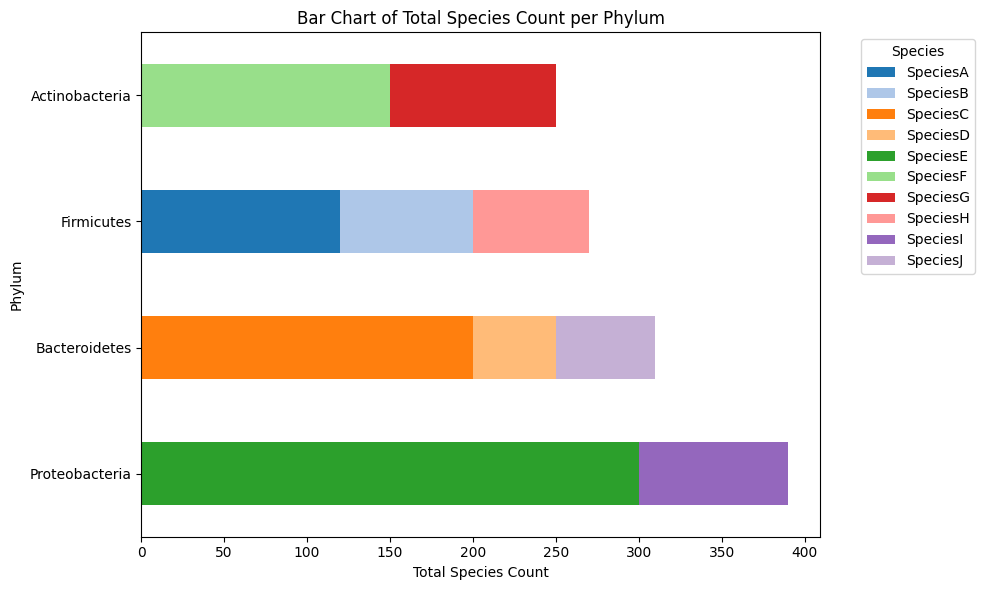

In [9]:
##Make the first main plot here; 
#Pivot the df to prepare for a stacked bar chart
pivot_df = df.pivot_table(index="phylum", columns="species", values="count", fill_value=0)

#Calc the total counts for each phylum then sort by high to low
pivot_df["total_count"] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values(by="total_count", ascending=False)
pivot_df = pivot_df.drop(columns="total_count")  # Drop the helper column

#Generate the horizontal stacked bar chart
plt.figure(figsize=(6, 6))

#Assign different colours to each species
colours = plt.cm.tab20(np.arange(len(pivot_df.columns)))

#Plot the horizontal stacked bars
pivot_df.plot(kind="barh", stacked=True, color=colours, figsize=(10, 6))

#Add plot labels and title
plt.ylabel("Phylum")
plt.xlabel("Total Species Count")
plt.title("Bar Chart of Total Species Count per Phylum")

#Add a legend for species
plt.legend(title="Species", bbox_to_anchor=(1.05, 1), loc='upper left')

#Save the plot as jpef and 300 DPI
output_path = "./total_species_count_stacked.jpeg"
plt.savefig(output_path, dpi=300, format="jpeg", bbox_inches="tight")
print(f"Plot saved to {output_path}")

#Show plot below as is
plt.tight_layout()
plt.show()


Plot saved to ./average_species_count.jpeg


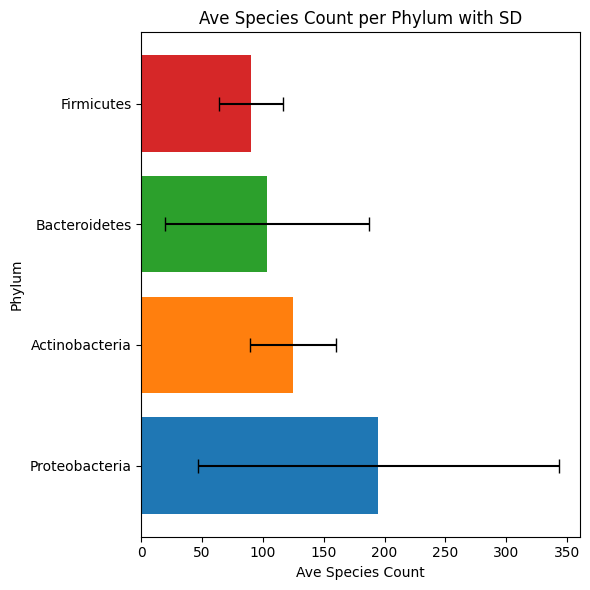

In [11]:
#Sort the df by average count from high to low
averages_df = averages_df.sort_values(by="average_count", ascending=False)

#Generate a horizontal bar plot for the average species count with SDs
plt.figure(figsize=(6, 6))

#Colour assign to batd
colours = plt.cm.tab10(np.arange(len(averages_df)))

#Plot the bars with error bars for SDs
plt.barh(averages_df["phylum"], averages_df["average_count"], xerr=averages_df["std_dev"], color=colours, capsize=5)

#Add plot labels&title
plt.ylabel("Phylum")
plt.xlabel("Ave Species Count")
plt.title("Ave Species Count per Phylum with SD")

#Save plot as jpef with 300 DPI
output_path = "./average_species_count.jpeg"
plt.savefig(output_path, dpi=300, format="jpeg")
print(f"Plot saved to {output_path}")

#Show plot below as is
plt.tight_layout()
plt.show()
